# The Muon Collection
```{warning}
Not all examples on this page have been updated to r22 and ServiceX 3. Examples that have not been updated will be marked using a similar warning. These examples will be updated soon.
```
Muons are single-track particles. They can be reconstructed from hits in the tracking, calorimeter, and, of course, the muons chambers. Like electrons, there are several versions of the same muons that one can access (`Tight`, `Medium`, etc.).


In [1]:
from config import get_data
from config import sx_f
from func_adl_servicex_xaodr22 import FuncADLQueryPHYSLITE

import matplotlib.pyplot as plt
import awkward as ak

import asyncio
from func_adl_servicex_xaodr21 import calib_tools

The default muon we fetch is the so-called `Medium` muon with `NonIso` isolation. Unfortunately, the MC we are working with for this demo contains very few muons!

In [2]:
query = FuncADLQueryPHYSLITE()
muons_per_event = (query
                   .Select(lambda e: e.Muons())
                   .Select(lambda muon: {
                            'pt': muon.Where(lambda m: (m.pt() / 1000 > 30)).Select(lambda m: m.pt() / 1000),
                        })
                  )

muon_data = get_data(muons_per_event, sx_f)

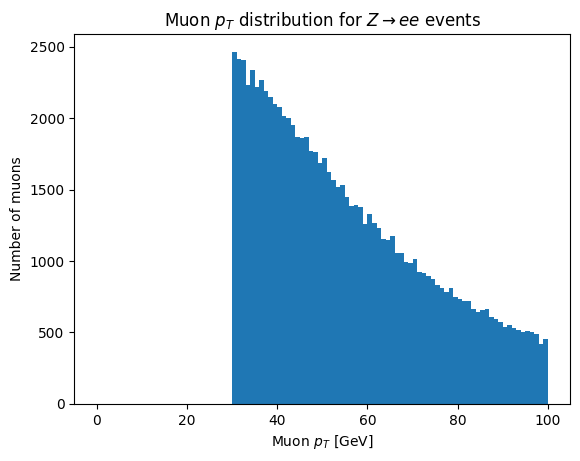

In [3]:
plt.hist(ak.flatten(muon_data.pt), bins=100, range=(0, 100))
plt.xlabel('Muon $p_T$ [GeV]')
plt.ylabel('Number of muons')
_ = plt.title('Muon $p_T$ distribution for $Z\\rightarrow ee$ events')

## Muon Types

```{warning}
This example has not been updated to r22 and ServiceX 3 yet.
```

Muons come in several different flavors. In this sample with very few muons, we can look at the different $\eta$ distributions for what muons are there. As with the [electrons](sec-ele-wp) we need to run three different queries (and we use the async keyword to run them in parallel):

In [4]:
import logging
# logging.basicConfig(level=logging.DEBUG)
# logging.getLogger("func_adl_xAOD.common.local_dataset").setLevel(level=logging.DEBUG)
# from servicex import ignore_cache
# with ignore_cache():
muon_working_points = ['Loose', 'Medium','Tight']
muons_async = [
    (calib_tools.query_update(ds, muon_working_point=wp)
        .SelectMany(lambda e: [mu.eta() for mu in e.Muons()])
        .AsAwkwardArray('eta')
        .value_async())
    for wp in muon_working_points
]
muons_wp = await asyncio.gather(*muons_async)

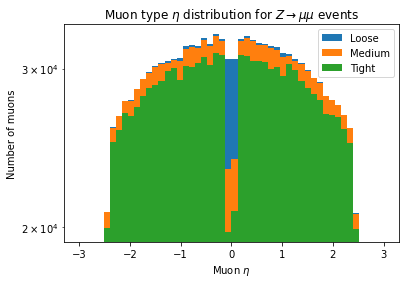

In [5]:
for idx, wp in list(enumerate(muon_working_points)):
    plt.hist(muons_wp[idx].eta, bins=50, range=(-3, 3), label=wp)
plt.xlabel('Muon $\\eta$')
plt.ylabel('Number of muons')
plt.yscale('log')
plt.title(r'Muon type $\eta$ distribution for $Z\rightarrow \mu\mu$ events')
_ = plt.legend()

## Calibration

```{warning}
This example has not been updated to r22 and ServiceX 3 yet.
```

By default the muons we pulled are `Medium` quality and calibrated. One can request different systematic errors using the `calibration` argument to the `Muons` method.

To grab the raw jets (without calibration) we just set the `calibrated` parameter to `None` (there is very little reason one will do this normally):

In [6]:
raw_muons = (ds
             .Select(lambda e: e.Muons(uncalibrated_collection = "Muons"))
             .Select(lambda l_muons: [m for m in l_muons if m.pt() > 30000.0])
             .Select(lambda l_muons: {
                 'pt': [m.pt() / 1000.0 for m in l_muons],
                 'eta': [m.eta() for m in l_muons],
                 'phi': [m.phi() for m in l_muons],
             })
             .AsAwkwardArray()
             .value())

The number of raw jets and the number of calibrated jets are quite different from the number of raw jets, so we'll need to match them in $\eta$ and $\phi$:

In [7]:
len(ak.flatten(raw_muons.pt)), len(ak.flatten(muons.pt))

(1153980, 838582)

In [8]:
raw_muons_matched = match_objects(muons, raw_muons)

Note the units along the x-axis here!!

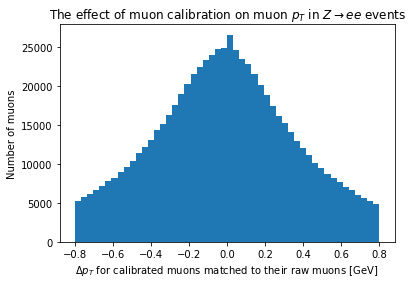

In [9]:
plt.hist(ak.flatten(muons.pt-raw_muons_matched.pt), bins=50, range=(-0.8, 0.8))
plt.xlabel('$\Delta p_T$ for calibrated muons matched to their raw muons [GeV]')
plt.ylabel('Number of muons')
_ = plt.title('The effect of muon calibration on muon $p_T$ in $Z\\rightarrow ee$ events')

If we instead want a particular systematic error, we need only name that error to get it back. Knowing what the names of the systematic errors, however, is not something that can be programmatically determined ahead of time. See the further information section at the end of this chapter to links to the ATLAS muon calibration info twiki.

In [10]:
sys_muon = (calib_tools.query_sys_error(ds, 'MUON_ID__1up')
           .Select(lambda e: e.Muons())
           .Select(lambda l_muons: [m for m in l_muons if m.pt() > 30000.0])
           .Select(lambda l_muons: {
               'pt': [m.pt() / 1000.0 for m in l_muons],
               'eta': [m.eta() for m in l_muons],
               'phi': [m.phi() for m in l_muons],
           })
           .AsAwkwardArray()
           .value())

In [11]:
sys_muons_matched = match_objects(muons, sys_muon)

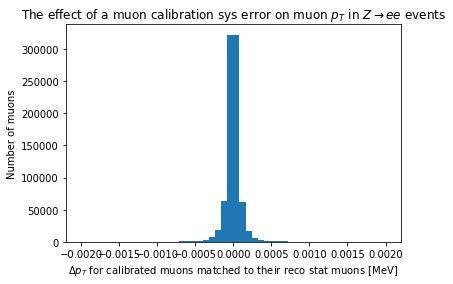

In [12]:
plt.hist(ak.flatten(muons.pt-sys_muons_matched.pt)/1000.0, bins=50, range=(-0.002, 0.002))
plt.xlabel('$\Delta p_T$ for calibrated muons matched to their reco stat muons [MeV]')
plt.ylabel('Number of muons')
_ = plt.title('The effect of a muon calibration sys error on muon $p_T$ in $Z\\rightarrow ee$ events')

## The Data Model

The data model when this documentation was last built is.

In [3]:
from func_adl_servicex_xaodr22.xAOD.muon_v1 import Muon_v1
help(Muon_v1)

Help on class Muon_v1 in module func_adl_servicex_xaodr22.xAOD.muon_v1:

class Muon_v1(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  author(self) -> 'func_adl_servicex_xaodr22.xAOD.muon_v1.Muon_v1.Author'
 |      A method
 |  
 |  charge(self) -> 'float'
 |      A method
 |  
 |  clearDecorations(self) -> 'bool'
 |      A method
 |  
 |  cluster(self) -> 'func_adl_servicex_xaodr22.xAOD.calocluster_v1.CaloCluster_v1'
 |      A method
 |  
 |  clusterLink(self) -> 'func_adl_servicex_xaodr22.elementlink_datavector_xaod_calocluster_v1__.ElementLink_DataVector_xAOD_CaloCluster_v1__'
 |      A method
 |  
 |  combinedTrackParticleLink(self) -> 'func_adl_servicex_xaodr22.elementlink_datavector_xaod_trackparticle_v1__.ElementLink_DataVector_xAOD_TrackParticle_v1__'
 |      A method
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  energyLossType(self) -> 'func_adl_servicex_xaodr22.xAOD.muon_v1.Muon_v1.EnergyLossType'
 |      A method
 |  
 |  eta(self) -> 'float'
 | 

## Further Information

* The [`xAOD::Muon_v1` C++ header file](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODMuon/xAODMuon/versions/Muon_v1.h) with all the inline documentation.
* The [Muon Recommendation Pages for R21](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/MCPAnalysisGuidelinesMC16) on the ATLAS TWiki